In [1]:
import xarray as xr
import fsspec
from kerchunk.combine import MultiZarrToZarr

from grixraz import find_files, create_references

## Reference and lazy load analysis files

In [2]:
# find all files to be referenced
PATH = "/scratch/fzanetta/tmp/hackathon/ANASURF23/lafsurf*"
files = find_files(PATH)
files = [f for f in files if "idx" not in f]
print(f"Found {len(files)} files")

# specify filter for eccodes scan of grib files
filter = {"typeOfLevel": "heightAboveGround", "level": [2, 10]}

# create references for all files
ref_files = create_references(files, n_workers=20, filter=filter)

# create MultiZarrToZarr aggregating all references
mzz = MultiZarrToZarr(
    ref_files, # list of references
    concat_dims = ['time'], # each reference file has different time
    identical_dims=['latitude', 'longitude', 'heightAboveGround', 'step'], # these are the same for all references
)
ana_d = mzz.translate()

# open the aggregated dataset
fs = fsspec.filesystem("reference", fo=ana_d, remote_options={'anon':True})
m = fs.get_mapper("")
ana_ds = xr.open_dataset(
    m, engine="zarr",
    backend_kwargs=dict(consolidated=False), 
    chunks={'time':1},
    decode_cf=True,
)


Found 1464 files


Creating references...:   0%|          | 0/1464 [00:00<?, ?it/s]

## Reference and lazy load first guess files

In [3]:
# find all files to be referenced
PATH = "/scratch/fzanetta/tmp/hackathon/FGSURF23/lffsurf*"
files = find_files(PATH)
files = [f for f in files if "idx" not in f]
print(f"Found {len(files)} files")

# specify filter for eccodes scan of grib files
filter = {"typeOfLevel": "heightAboveGround", "level": [2, 10]}

# create references for all files
ref_files = create_references(files, n_workers=20, filter=filter)

# create MultiZarrToZarr aggregating all references
mzz = MultiZarrToZarr(
    ref_files, # list of references
    concat_dims = ['time'], # each reference file has different time
    identical_dims=['latitude', 'longitude', 'heightAboveGround', 'step'], # these are the same for all references
)
fg_d = mzz.translate()

# open the aggregated dataset
fs = fsspec.filesystem("reference", fo=fg_d, remote_options={'anon':True})
m = fs.get_mapper("")
fg_ds = xr.open_dataset(
    m, engine="zarr",
    backend_kwargs=dict(consolidated=False), 
    chunks={'time':1},
    decode_cf=True,
)
fg_ds

Found 1464 files


Creating references...:   0%|          | 0/1464 [00:00<?, ?it/s]

<xarray.Dataset>
Dimensions:            (time: 1464, y: 786, x: 1170)
Coordinates:
    heightAboveGround  float64 ...
    latitude           (y, x) float64 dask.array<chunksize=(786, 1170), meta=np.ndarray>
    longitude          (y, x) float64 dask.array<chunksize=(786, 1170), meta=np.ndarray>
    step               timedelta64[ns] ...
  * time               (time) datetime64[ns] 2023-05-31T23:00:00 ... 2023-08-...
    valid_time         (time) datetime64[ns] dask.array<chunksize=(1,), meta=np.ndarray>
Dimensions without coordinates: y, x
Data variables:
    d2m                (time, y, x) float64 dask.array<chunksize=(1, 786, 1170), meta=np.ndarray>
    fg10               (time, y, x) float64 dask.array<chunksize=(1, 786, 1170), meta=np.ndarray>
    mn2t               (time, y, x) float64 dask.array<chunksize=(1, 786, 1170), meta=np.ndarray>
    mx2t               (time, y, x) float64 dask.array<chunksize=(1, 786, 1170), meta=np.ndarray>
    t2m                (time, y, x) float64 dask.array<chunksize=(1, 786, 1170), meta=np.ndarray>
    u10                (time, y, x) float64 dask.array<chunksize=(1, 786, 1170), meta=np.ndarray>
    v10                (time, y, x) float64 dask.array<chunksize=(1, 786, 1170), meta=np.ndarray>
Attributes:
    GRIB_centre:             lssw
    GRIB_centreDescription:  Zurich
    GRIB_edition:            2
    GRIB_subCentre:          255
    institution:             Zurich

## Reading and computing

In [4]:
diff_ds = fg_ds.set_xindex("valid_time").reset_index("time") - ana_ds.set_xindex("valid_time").reset_index("time")
daily_cycle = diff_ds["t2m"].groupby("valid_time.hour").mean()

## Plotting

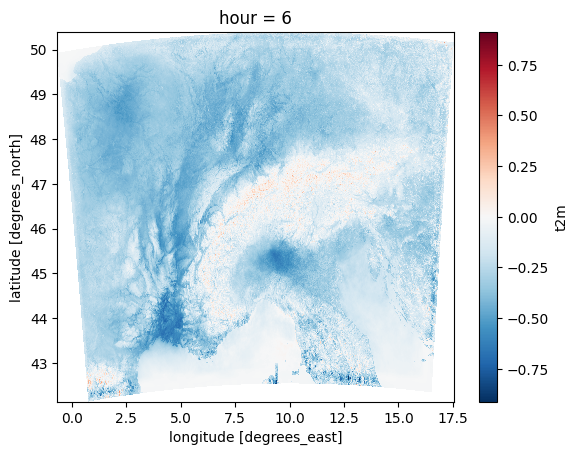

In [5]:
daily_cycle.sel(hour=6).plot.pcolormesh(
    x="longitude", y="latitude", cmap="RdBu_r"
)